# Generate space filling curve by solving travelling salesman problem



Space filling curve is a one-dimensional curve that fills maximally some space of a given dimensonality. While space filling curves have many practical applications. Here we are going to use them to solve rather a trivial task of generating a graphics. The problem has very elegant mathematical solutions such as the [Hilbert curve](https://en.wikipedia.org/wiki/Hilbert_curve), they are limited to the kind of the space they can use.

Alternatively, the space filling curve can be obtained by solving the travelling salesman problem (TSP), which can be summarised as following:

    Given a set of cities, find the closed path that would pass exactly one time through all the cities. At the end, the travelling salesman should return to the city of departure.
    
If we equate the cities with nodes in a n-dimensional geometry, we can easily see the relation between the TSP and space-filling curves.

## Input data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import hashlib
from numpy.testing import assert_allclose

First, let's load an image for processing:

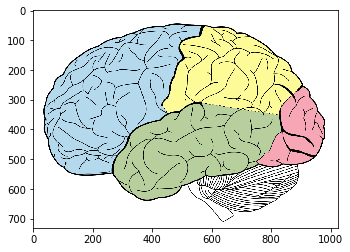

In [2]:
img = skimage.io.imread('/home/bartosz/Downloads/1024px-Lobes_of_the_brain_NL.svg.png')
plt.imshow(img)

Now we define nodes on a rectangular grid that would cover the shape of the brain.

(-0.15000000000000013, 25.15, -17.75, -1.25)

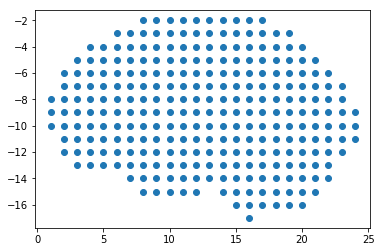

In [3]:
img_flat = img.mean(axis=2)
strides=(40, 40)

pixel_mask = (img_flat[::strides[0], ::strides[1]])>0

X, Y = np.mgrid[:pixel_mask.shape[0], :pixel_mask.shape[1]]

X = X[pixel_mask]
Y = Y[pixel_mask]

pixel_mask.shape

Y, X = -X, Y

plt.plot(X, Y, 'o')
plt.axis('equal')

## Finding space filling curve

Define helper functions

In [4]:
def total_length(X, Y):
    "calculate the total length of the curve"
    dist = np.sum(np.abs(np.diff(X)) + np.abs(np.diff(Y)))
    dist += np.abs(X[-1]-X[0]) + np.abs(Y[-1]-Y[0])
    return dist

def swap_edge(X, i, j):
    "swap two edges (starting at index i and )"
    if i == j:
        return X
    Xnew = np.concatenate((X[:i+1], X[j:i:-1], X[j+1:]))
 
    assert len(Xnew) == len(X)

    return Xnew

assert (swap_edge([1, 2, 3, 4, 5, 6], 1, 3) == np.array([1, 2, 4, 3, 5, 6])).all()

The curve is defined in  one dimensional arrays of X and Y coordinates of the curve. The consecutive notes are connected, i.e. the start and end points of edges are:

`(X[i], Y[i]) -> (X[i+1], Y[i+1])`. 

The curve is closed, such that the last node is connected to the first one:

`(X[-1], Y[-1]) -> (X[0], Y[0])`

## 2-opt swap algorithm

To solve the travelling salesman problem, we will use an algorithm called [2-opt swap](https://en.wikipedia.org/wiki/2-opt). The idea is to randomly select two edges and swap them if the curve after the swap becomes shorter. 

In [5]:
def initialize_curve(X, Y):
    "randomize the initial order of the nodes"
    Xfull = X.copy()
    Yfull = Y.copy()

    i = np.random.rand(len(Xfull)).argsort()
    Xfull = Xfull[i]
    Yfull = Yfull[i]
    
    return Xfull, Yfull
    

def deterministic(delta):
    "swap edges if curve becomes shorter"
    
    return delta < 0

def tsp_2_swap(Xfull, Yfull, max_iter, acceptance_function=deterministic):
    """take the coordinates of the nodes and return the curve node sequence minimizing the length.
    
    Returns:
    
        Xfull, Yfull - new sequence of nodes
        total_delta - increase (if positive) or decrease of the curve length compared to the inital length
    
    """
    
    total_delta = 0
    length_convergence = []
    report_step = max_iter // 30
    
    imax = len(Xfull) - 1

    for iteration in range(max_iter):

        i, j = np.random.randint(0, imax, size=(2,))
        if i > j:
            j, i = i, j
        if not j > i+1:
            continue
            
        i_1 = (i + 1) % len(Xfull)
        j_1 = (j + 1) % len(Xfull)
        
        # calculate the difference of curve lengths after swapping two edges
        delta = -(np.abs(Xfull[i] - Xfull[i_1]) + np.abs(Yfull[i] - Yfull[i_1]))
        delta -= np.abs(Xfull[j] - Xfull[j_1]) + np.abs(Yfull[j] - Yfull[j_1])
        delta += np.abs(Xfull[i] - Xfull[j]) + np.abs(Yfull[i] - Yfull[j])
        delta += np.abs(Xfull[i_1] - Xfull[j_1]) + np.abs(Yfull[i_1] - Yfull[j_1])

        if acceptance_function(delta):
            total_delta += delta
            Xfull = swap_edge(Xfull, i, j)
            Yfull = swap_edge(Yfull, i, j)
            
        if iteration % report_step:
            length_convergence.append((iteration, total_delta))
            
    length_convergence = np.array(length_convergence)
    return Xfull, Yfull, total_delta, length_convergence


def plot_curve(X, Y, ax=None):
    "plots the curve going through the nodes"
    
    Xclosed = np.append(X, X[0])
    Yclosed = np.append(Y, Y[0])
    
    if not ax:
        ax = plt.subplot(111)
    
    ax.plot(Xclosed, Yclosed, 'k-', linestyle='steps')
    ax.set_xticks([])
    ax.set_yticks([])
    for sp in ax.spines.values():
        sp.set_visible(False)

Now let's try out the algorithm. First we initialize a random curve through the nodes. It won't look very optimal.

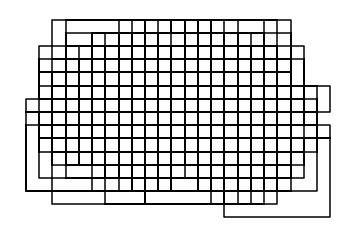

In [6]:
Xfull, Yfull = initialize_curve(X, Y)

plot_curve(Xfull, Yfull)

Now, we can try the swapping algorithm:

In [7]:
max_iter = 200000 # number of iterations

initial_length = total_length(Xfull, Yfull)
Xfull, Yfull, total_delta, convergence = tsp_2_swap(Xfull, Yfull, max_iter)
final_length_2swap = initial_length + total_delta
assert total_length(Xfull, Yfull) == final_length_2swap

Text(0, 0.5, 'curve length')

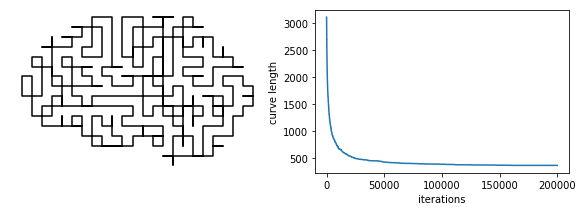

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_curve(Xfull, Yfull, axes[0])

axes[1].plot(convergence[:, 0], initial_length + convergence[:, 1])
axes[1].set_xlabel('iterations')
axes[1].set_ylabel('curve length')

This looks better, but still there are a lot of crossings. Note that the length of the curve converged, so most likely we reached a local minimum.

## Simulated annealing

In order to avoid the local minima of the curve length and find the shortest curve, we will also use a simulated annealing (SA). SA is inspired by the way the materials, such as glass, can be heated and then slowly cooled down, such that the atoms relax to the state of lowest energy and hence the highest durability of the material.

This technique of annealing can be also simulated numerically. In this optimization scheme, even swaps that increase the length of the curve can be accepted. The probability that such swaps are accepted depends on a parameter called "temperature" (as an analogy to physical temperature) -- the higher the temperature the more swaps are accepted. The temperature is gradually decreased during the optimization, until it's so low that no more distance-increasing swaps are accepted.

This scheme makes it possible to escape local minima and find a better global solution.

In [9]:
def simulated_annealing(delta):
    "acceptance function for simulated annealing"
    return delta < 0 or np.random.rand() < np.exp(-delta / temperature)

In [10]:
# parameters

max_iter = 750000 # number of interation for each SA step
#max_iter = 75 
temp_steps = 30 # number of temperature steps
temperatures = np.logspace(2, -2, temp_steps) # list of temperature for SA

Xfull, Yfull = initialize_curve(X, Y)
curve_length = total_length(Xfull, Yfull)
annealing_progress = []
for temperature in temperatures:
    Xfull, Yfull, total_delta, _ = tsp_2_swap(Xfull, Yfull, max_iter, 
                                            acceptance_function=simulated_annealing)
    curve_length += total_delta

    print("Temperature: {:02.02f}\t Length of shortest curve: {}".format(temperature, curve_length))
    annealing_progress.append((temperature, curve_length))

assert_allclose(curve_length, total_length(Xfull, Yfull))

Temperature: 100.00	 Length of shortest curve: 3036
Temperature: 72.79	 Length of shortest curve: 3024
Temperature: 52.98	 Length of shortest curve: 3086
Temperature: 38.57	 Length of shortest curve: 2762
Temperature: 28.07	 Length of shortest curve: 2936
Temperature: 20.43	 Length of shortest curve: 2636
Temperature: 14.87	 Length of shortest curve: 2672
Temperature: 10.83	 Length of shortest curve: 2304
Temperature: 7.88	 Length of shortest curve: 2192
Temperature: 5.74	 Length of shortest curve: 1922
Temperature: 4.18	 Length of shortest curve: 1568
Temperature: 3.04	 Length of shortest curve: 1316
Temperature: 2.21	 Length of shortest curve: 1012
Temperature: 1.61	 Length of shortest curve: 800
Temperature: 1.17	 Length of shortest curve: 646
Temperature: 0.85	 Length of shortest curve: 538
Temperature: 0.62	 Length of shortest curve: 394
Temperature: 0.45	 Length of shortest curve: 344
Temperature: 0.33	 Length of shortest curve: 310
Temperature: 0.24	 Length of shortest curve: 29

Text(0, 0.5, 'curve length')

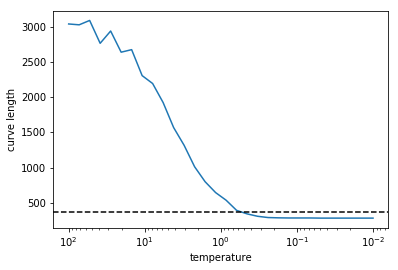

In [11]:
annealing_progress = np.array(annealing_progress)
ax = plt.subplot(111)
plt.semilogx(annealing_progress[:, 0], annealing_progress[:, 1])
plt.axhline(final_length_2swap, linestyle='--', color='k')
ax.invert_xaxis()
plt.xlabel('temperature')
plt.ylabel('curve length')

The graph above shows the length of a shortest path as a function of the temperature. Note that the temperature decreases during the optimization process (going left to right  along the X axis) and that it's plotted in the logarithmic scale. We find that the final length of the path is shortest than the one obtained by simple 2-opt swap algorithm (shown with the dashed line).

## Result

Now we can plot the final curve and save the results:

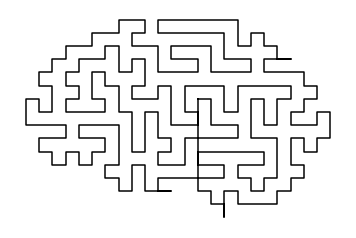

In [12]:
fig = plt.figure()
plot_curve(Xfull, Yfull)

In [13]:
h = hashlib.md5(np.concatenate((Xfull, Yfull)))
uid = h.hexdigest()[:6]
fig.savefig("brain_{}_{}.svg".format(curve_length, uid))
np.savez("brain_{}_{}.npz".format(curve_length, uid), X=Xfull, Y=Yfull, max_iter=max_iter, temperatures=temperatures)

## Conclusion

There are a few interesting lessons from this exercise:

1) Link between computation and geometry

  We showed that space-filling curve can be found by a solution to a travelling salesman problem. Travelling salesman problem (TSP) is a very important problem in the computation theory. It can be shown that it belongs to a class of hard computational problems called NP-complete. These problems can be translated one into the other, so solving one of them solves the entire class.

2) Optimization theory.

  We showed that a naive solution to TSP gets stuck in a local minimum. Implementation of more sophisticated optimization algorithms can bring us close to the global minimum. Development of better optimization schemes is at the heart of most computation-intensive disciplines such as machine learning and AI.
  
3) Sampling methods are ubiquitus.

  Simulated annealing is closely related to the Metropolis-Hasting sampling approach based on Markov Chain Monte Carlo. This method is very important for sampling from high-dimensional probability distribution for example, in Bayesian inference.
  
4) Effect of constraints.

  You can check that removing the constraint that the curve must be closed (first and last node are connected) changes completely the solution. If we can freely choose the initial and final node, the path becomes rather trivial. For example, it could simply scan the grid row by row starting from the top left node to the bottom right.
  
5) Human brain.

  The human brain, whose shape I took for the presentation of the algorithm, is probably the universe's most sophisticated computational machine (at least from the ones that we are aware of). It's not suprise than that it motivates much of the research in ML and AI.
